In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/net/fs11/d0/emfreese/social_cost_carbon/tsd_2021_all_mc_runs.csv', header = [0,1,2,3,4], index_col = 0)
df = df.transpose()  #data is in 2007$/metric ton
df = df.droplevel(['Model','Scenario']).xs('2020')

#### read in emissions data ####
gmodel_egrid = xr.open_zarr(f'./final_data/gmodel_egrid_emissions_ds.zarr')


In [3]:
gmodel_egrid

<xarray.Dataset>
Dimensions:                            (ORISCode: 9824, date: 8760, model_name: 3)
Coordinates:
  * ORISCode                           (ORISCode) int64 2 3 4 ... 100062 100063
  * date                               (date) datetime64[ns] 2017-01-01 ... 2...
    fueltype                           (model_name, ORISCode) object dask.array<chunksize=(3, 9824), meta=np.ndarray>
  * model_name                         (model_name) object 'nonuc_model' ... ...
    regionname                         (model_name, ORISCode) object dask.array<chunksize=(3, 9824), meta=np.ndarray>
Data variables: (12/32)
    Capacity                           (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    Generator nameplate capacity (MW)  (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    PLCH4RTA                           (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    PLCO2RTA                           (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    PLN2ORTA                           (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    PLNOXRTA                           (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    ...                                 ...
    model_annual_NO2_conc              (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    model_annual_NO_conc               (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    model_annual_SO2_conc              (model_name, ORISCode) float64 dask.array<chunksize=(3, 9824), meta=np.ndarray>
    model_capafactor                   (model_name, ORISCode, date) float64 dask.array<chunksize=(1, 614, 548), meta=np.ndarray>
    modelgeneration                    (model_name, ORISCode, date) float64 dask.array<chunksize=(1, 614, 548), meta=np.ndarray>
    planttype                          (model_name, ORISCode) object dask.array<chunksize=(3, 9824), meta=np.ndarray>
Attributes:
    group:    All

In [4]:
#### CO2 values ####
normal_CO2 = ((gmodel_egrid.sel(model_name = 'normal_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'normal_model')['annual_modelgeneration']).sum()*.001).values #metric tons
nonuc_CO2 = ((gmodel_egrid.sel(model_name = 'nonuc_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'nonuc_model')['annual_modelgeneration']).sum()*.001).values #metric tons
nonuc_coal_CO2 = ((gmodel_egrid.sel(model_name = 'nonuc_nocoal_model')['PLCO2RTA']*gmodel_egrid.sel(model_name = 'nonuc_nocoal_model')['annual_modelgeneration']).sum()*.001).values #metric tons
dif_nuc_CO2 = nonuc_CO2 - normal_CO2
dif_coal_CO2 = nonuc_coal_CO2 - normal_CO2

In [5]:
#### datasets for normal and no nuclear cost of CO2 emissions ####
df_nonuc = (df*nonuc_CO2)
df_normal = (df*normal_CO2)
df_nonuc_coal = (df*nonuc_coal_CO2)
df_nonuc_dif = (df*dif_nuc_CO2)
df_nonuc_coal_dif = (df*dif_coal_CO2)

/tmp/ipykernel_613994/1584542865.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  x = df.loc[(scc, 'CO2')].values.flatten()*1e-9 #drop the levels for model, scenario type, choose 2010 levels
/tmp/ipykernel_613994/1584542865.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_613994/1584542865.py:20: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'Figures/scc_{nm}.png', dpi = 150, bbox_inches = 'tight')
/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


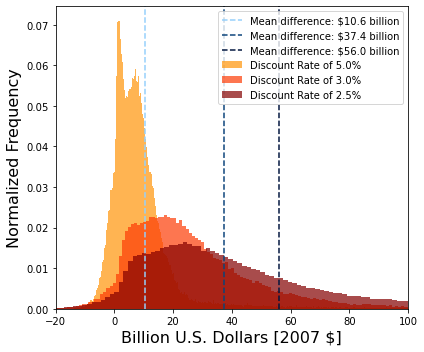

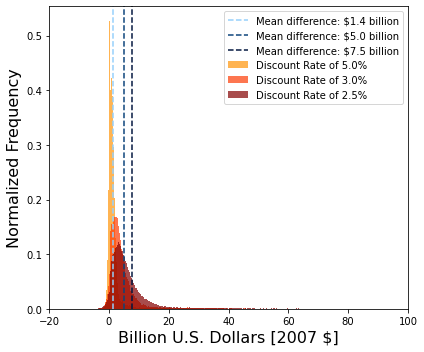

In [6]:
#### plot our SCC by discount rate ####
colors = ["tangerine","red orange",'dark red']
colors_mean = ["light blue","twilight blue",'navy']
bin_vals = [100.,1000.]

for df, nm in zip([df_nonuc_dif, df_nonuc_coal_dif],['nonuc','nonuc_coal']):
    fig, axes = plt.subplots(1,1, figsize=[6,5],)
    for idx_c, scc in enumerate(['5.0%','3.0%','2.5%']):
        x = df.loc[(scc, 'CO2')].values.flatten()*1e-9 #drop the levels for model, scenario type, choose 2010 levels
        mean = x.mean()
        n, bins, patches = plt.hist(x=x, bins='auto', color=sns.xkcd_palette(colors)[idx_c],label = f'Discount Rate of {scc}',
                                alpha=0.7, density = True)
        plt.axvline(mean, color=sns.xkcd_palette(colors_mean)[idx_c], linestyle='--', label = f'Mean difference: ${np.round(mean,1)} billion')
        plt.legend()
        #plt.title(f'Monetized Social Impact', fontsize = 20)
        plt.xlabel('Billion U.S. Dollars [2007 $]', fontsize = 16)
        plt.ylabel('Normalized Frequency', fontsize = 16)
        plt.xlim(-20,100)
    plt.tight_layout()
    plt.savefig(f'Figures/scc_{nm}.png', dpi = 150, bbox_inches = 'tight')

## Mortality Cost Carbon

In [7]:
d = {'baseline': [-1.71e-4, 2.26e-4, 6.78e-4], 'optimal': [-2.16e-4, 1.07e-4, 5.22e-4]}
df_MCC = pd.DataFrame(data=d, index=pd.Index(['low', 'central','high']))
df_MCC


,baseline,optimal
low,-0.000171,-0.000216
central,0.000226,0.000107
high,0.000678,0.000522


In [9]:
dif_nuc_CO2*df_MCC

,baseline,optimal
low,-125220.704194,-158173.521087
central,165496.369285,78354.475724
high,496489.107856,382252.675960


In [8]:
dif_coal_CO2*df_MCC

,baseline,optimal
low,-16858.341030,-21294.746564
central,22280.614461,10548.786493
high,66841.843383,51462.304197
